# Model Training

In [4]:
import pandas as pd

df = pd.read_csv('normalized_data.csv')

In [5]:
X = df.drop('ChurnLabel', axis=1)
y = df['ChurnLabel']

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Encode target variable ('No' -> 0, 'Yes' -> 1)
y_encoded = le.fit_transform(y)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y)

In [8]:
import dagshub

# dagshub.init(repo_owner='hrootscraft', repo_name='my-book', mlflow=True)
DAGSHUB_TOKEN = dagshub.auth.get_token()

Accessing as hrootscraft

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
import math

class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns_to_drop = ['Country', 'State', 'CustomerID', 'Latitude',
                               'Longitude', 'ChurnScore', 'CLTV', 
                               'ChurnReason', 'ZipCode', 'City']
        self.numeric_features = ['TenureMonths', 'MonthlyCharges', 'TotalCharges']
        self.categorical_features = None  # Will be set during fit
        self.scaler = StandardScaler()
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.encoded_feature_names = None

    def _impute_total_charges(self, X):
        X_ = X.copy()
        for index, row in X_.iterrows():
            if math.isnan(row['TotalCharges']):
                X_.at[index, 'TotalCharges'] = (
                    X_.at[index, 'MonthlyCharges'] * X_.at[index, 'TenureMonths']
                )
        return X_

    def fit(self, X, y=None):
        # Set categorical features (excluding target)
        self.categorical_features = [col for col in X.select_dtypes(include=['object']).columns 
                                   if col not in self.columns_to_drop + ['ChurnLabel']]
        
        X_ = X.copy()
        X_ = self._impute_total_charges(X_)
        X_ = X_.drop(columns=self.columns_to_drop, errors='ignore')
        X_['TotalCharges'] = np.log1p(X_['TotalCharges'])
        
        self.scaler.fit(X_[self.numeric_features])
        self.encoder.fit(X_[self.categorical_features])
        
        self.encoded_feature_names = []
        for i, feature in enumerate(self.categorical_features):
            feature_categories = self.encoder.categories_[i]
            self.encoded_feature_names.extend([f"{feature}_{cat}" for cat in feature_categories])
        
        return self

    def transform(self, X):
        X_ = X.copy()
        X_ = self._impute_total_charges(X_)
        X_ = X_.drop(columns=self.columns_to_drop, errors='ignore')
        X_['TotalCharges'] = np.log1p(X_['TotalCharges'])
        
        X_scaled = pd.DataFrame(
            self.scaler.transform(X_[self.numeric_features]),
            columns=self.numeric_features,
            index=X_.index
        )
        
        X_encoded = pd.DataFrame(
            self.encoder.transform(X_[self.categorical_features]),
            columns=self.encoded_feature_names,
            index=X_.index
        )
        
        return pd.concat([X_scaled, X_encoded], axis=1)

In [21]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import GridSearchCV, cross_validate
import mlflow
from sklearn.pipeline import Pipeline
import time, os
from mlflow.models import infer_signature

# Set MLflow tracking URI and credentials
MLFLOW_TRACKING_URI = "https://dagshub.com/hrootscraft/my-book.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'hrootscraft'
os.environ['MLFLOW_TRACKING_PASSWORD'] = DAGSHUB_TOKEN
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
mlflow.set_experiment("churn_prediction")


def train_logistic_regression(X_train, X_test, y_train, y_test, cv_folds=5):
    """
    Trains and evaluates the model with cross-validation and hyperparameter tuning
    """
    with mlflow.start_run(run_name="logistic_regression"):
        t1 = time.time()
        
        # Create pipeline
        pipeline = Pipeline([
            ('preprocessor', CustomPreprocessor()),
            ('classifier', LogisticRegression())
        ])
        
        # Define parameter grid
        param_grid = {
            'classifier__C': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4],
            'classifier__solver': ['liblinear'],
            'classifier__class_weight': ['balanced']
        }
        
        # Perform GridSearchCV
        grid_search = GridSearchCV(
            pipeline, param_grid, 
            scoring='f1', 
            cv=cv_folds, 
            n_jobs=-1, 
            verbose=1
        )
        
        # Fit the model
        grid_search.fit(X_train, y_train)
        
        # Log best parameters
        mlflow.log_params(grid_search.best_params_)
        
        # Perform cross-validation with best model
        cv_results = cross_validate(
            grid_search.best_estimator_,
            X_train, y_train,
            cv=cv_folds,
            scoring='f1',
            return_train_score=True
        )
        
        # Log cross-validation results
        mlflow.log_metric("cv_f1_mean", cv_results['test_score'].mean())
        mlflow.log_metric("cv_f1_std", cv_results['test_score'].std())
        
        # Get predictions on test set
        y_pred = grid_search.predict(X_test)
        
        # Calculate metrics
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
        # Log metrics
        metrics = {
            "test_f1": f1,
            "true_negatives": tn,
            "false_positives": fp,
            "false_negatives": fn,
            "true_positives": tp
        }
        mlflow.log_metrics(metrics)
        
        # Log model
        signature = infer_signature(X_test, y_pred)
        mlflow.sklearn.log_model(
            sk_model=grid_search.best_estimator_,
            artifact_path="churn_model",
            signature=signature,
            input_example=X_test.iloc[0:1],
            registered_model_name="LogisticRegression"
        )
        
        t2 = time.time()
        print(f"Training completed in {t2-t1:.2f} seconds")
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best CV f1-score: {grid_search.best_score_:.4f}")
        print(f"Test f1-score: {f1:.4f}")
        print("\nConfusion Matrix:")
        print(f"TN: {tn}, FP: {fp}")
        print(f"FN: {fn}, TP: {tp}")
        
        return grid_search.best_estimator_, f1

In [11]:
logi_model = train_logistic_regression(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/rutuja/miniconda3/envs/jupyterbook/lib/python3.10/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LogisticRegression' already exists. Creating a new version of this model...
2024/12/22 17:41:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish c

Training completed in 25.20 seconds
Best parameters: {'classifier__C': 100.0, 'classifier__class_weight': 'balanced', 'classifier__solver': 'liblinear'}
Best CV f1-score: 0.6498
Test f1-score: 0.6253

Confusion Matrix:
TN: 756, FP: 279
FN: 77, TP: 297
🏃 View run logistic_regression at: https://dagshub.com/hrootscraft/my-book.mlflow/#/experiments/0/runs/e5d2f47bda584bf382ae944d0b661299
🧪 View experiment at: https://dagshub.com/hrootscraft/my-book.mlflow/#/experiments/0


In [22]:
def train_ridge_classifier(X_train, X_test, y_train, y_test, cv_folds=5):
    """
    Trains and evaluates Ridge Classifier with cross-validation and hyperparameter tuning
    """
    with mlflow.start_run(run_name="ridge_classifier"):
        t1 = time.time()
        # Create pipeline
        pipeline = Pipeline([
            ('preprocessor', CustomPreprocessor()),
            ('classifier', RidgeClassifier())
        ])
        
        # Define parameter grid
        param_grid = {
            'classifier__alpha': [0.1, 1.0, 10.0, 100.0],
            'classifier__class_weight': ['balanced'],
            'classifier__solver': ['auto', 'svd', 'cholesky']
        }
        
        # Perform GridSearchCV
        grid_search = GridSearchCV(
            pipeline, param_grid,
            scoring='f1',
            cv=cv_folds,
            n_jobs=-1,
            verbose=1
        )
        
        # Rest of the code follows the same pattern as your logistic regression
        grid_search.fit(X_train, y_train)
        mlflow.log_params(grid_search.best_params_)
        
        cv_results = cross_validate(
            grid_search.best_estimator_,
            X_train, y_train,
            cv=cv_folds,
            scoring='f1',
            return_train_score=True
        )
        
        # Log cross-validation results
        mlflow.log_metric("cv_f1_mean", cv_results['test_score'].mean())
        mlflow.log_metric("cv_f1_std", cv_results['test_score'].std())
        
        y_pred = grid_search.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
        metrics = {
            "test_f1": f1,
            "true_negatives": tn,
            "false_positives": fp,
            "false_negatives": fn,
            "true_positives": tp
        }
        mlflow.log_metrics(metrics)
        
        signature = infer_signature(X_test, y_pred)
        mlflow.sklearn.log_model(
            sk_model=grid_search.best_estimator_,
            artifact_path="ridge_model",
            signature=signature,
            input_example=X_test.iloc[0:1],
            registered_model_name="RidgeClassifier"
        )
        
        t2 = time.time()
        print(f"Training completed in {t2-t1:.2f} seconds")
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best CV f1-score: {grid_search.best_score_:.4f}")
        print(f"Test f1-score: {f1:.4f}")
        print("\nConfusion Matrix:")
        print(f"TN: {tn}, FP: {fp}")
        print(f"FN: {fn}, TP: {tp}")
        
        return grid_search.best_estimator_, f1

In [13]:
ridge_model = train_ridge_classifier(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/rutuja/miniconda3/envs/jupyterbook/lib/python3.10/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'RidgeClassifier' already exists. Creating a new version of this model...
2024/12/22 17:42:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish crea

Training completed in 26.72 seconds
Best parameters: {'classifier__alpha': 100.0, 'classifier__class_weight': 'balanced', 'classifier__solver': 'auto'}
Best CV f1-score: 0.6464
Test f1-score: 0.6184

Confusion Matrix:
TN: 741, FP: 294
FN: 75, TP: 299
🏃 View run ridge_classifier at: https://dagshub.com/hrootscraft/my-book.mlflow/#/experiments/0/runs/d987da39a0c1498396bee34fa7ab6de2
🧪 View experiment at: https://dagshub.com/hrootscraft/my-book.mlflow/#/experiments/0


In [23]:
from sklearn.ensemble import RandomForestClassifier

def train_random_forest_classifier(X_train, X_test, y_train, y_test, cv_folds=5):
    """
    Trains and evaluates Random Forest Classifier with cross-validation and hyperparameter tuning
    """
    with mlflow.start_run(run_name="random_forest_classifier"):
        t1 = time.time()
        pipeline = Pipeline([
            ('preprocessor', CustomPreprocessor()),
            ('classifier', RandomForestClassifier(random_state=42))
        ])
        
        param_grid = {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [10, 20, 30, None],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4],
            'classifier__class_weight': ['balanced']
        }
        
        grid_search = GridSearchCV(
            pipeline, param_grid,
            scoring='f1',
            cv=cv_folds,
            n_jobs=-1,
            verbose=1
        )
        
        # Rest follows the same pattern
        grid_search.fit(X_train, y_train)
        mlflow.log_params(grid_search.best_params_)
        
        cv_results = cross_validate(
            grid_search.best_estimator_,
            X_train, y_train,
            cv=cv_folds,
            scoring='f1',
            return_train_score=True
        )
        
        mlflow.log_metric("cv_f1_mean", cv_results['test_score'].mean())
        mlflow.log_metric("cv_f1_std", cv_results['test_score'].std())
        
        y_pred = grid_search.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
        metrics = {
            "test_f1": f1,
            "true_negatives": tn,
            "false_positives": fp,
            "false_negatives": fn,
            "true_positives": tp
        }
        mlflow.log_metrics(metrics)
        
        signature = infer_signature(X_test, y_pred)
        mlflow.sklearn.log_model(
            sk_model=grid_search.best_estimator_,
            artifact_path="random_forest_model",
            signature=signature,
            input_example=X_test.iloc[0:1],
            registered_model_name="RandomForestClassifier"
        )
        
        t2 = time.time()
        print(f"Training completed in {t2-t1:.2f} seconds")
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best CV f1-score: {grid_search.best_score_:.4f}")
        print(f"Test f1-score: {f1:.4f}")
        print("\nConfusion Matrix:")
        print(f"TN: {tn}, FP: {fp}")
        print(f"FN: {fn}, TP: {tp}")
        
        return grid_search.best_estimator_, f1

In [15]:
rndf_model = train_random_forest_classifier(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/home/rutuja/miniconda3/envs/jupyterbook/lib/python3.10/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'RandomForestClassifier' already exists. Creating a new version of this model...
2024/12/22 17:47:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to fini

Training completed in 327.47 seconds
Best parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Best CV f1-score: 0.6501
Test f1-score: 0.6317

Confusion Matrix:
TN: 796, FP: 239
FN: 91, TP: 283
🏃 View run random_forest_classifier at: https://dagshub.com/hrootscraft/my-book.mlflow/#/experiments/0/runs/630bd76fb60c43e4a7f4322241ea58af
🧪 View experiment at: https://dagshub.com/hrootscraft/my-book.mlflow/#/experiments/0


# COMPARE F1 SCORES

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Train the models and get their F1 scores
logistic_regression_model, logistic_regression_f1 = train_logistic_regression(X_train, X_test, y_train, y_test)
ridge_classifier_model, ridge_classifier_f1 = train_ridge_classifier(X_train, X_test, y_train, y_test)
random_forest_model, random_forest_f1 = train_random_forest_classifier(X_train, X_test, y_train, y_test)

# Store the F1 scores
model_names = ['Logistic Regression', 'Ridge Classifier', 'Random Forest']
f1_scores = [logistic_regression_f1, ridge_classifier_f1, random_forest_f1]

# Print the F1 scores for verification
for model, f1 in zip(model_names, f1_scores):
    print(f"{model}: F1 Score = {f1:.4f}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/rutuja/miniconda3/envs/jupyterbook/lib/python3.10/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LogisticRegression' already exists. Creating a new version of this model...
2024/12/22 19:23:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish c

Training completed in 22.97 seconds
Best parameters: {'classifier__C': 100.0, 'classifier__class_weight': 'balanced', 'classifier__solver': 'liblinear'}
Best CV f1-score: 0.6498
Test f1-score: 0.6253

Confusion Matrix:
TN: 756, FP: 279
FN: 77, TP: 297
🏃 View run logistic_regression at: https://dagshub.com/hrootscraft/my-book.mlflow/#/experiments/0/runs/43c5161c884d4d7388aa85dd2149d143
🧪 View experiment at: https://dagshub.com/hrootscraft/my-book.mlflow/#/experiments/0
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/rutuja/miniconda3/envs/jupyterbook/lib/python3.10/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'RidgeClassifier' already exists. Creating a new version of this model...
2024/12/22 19:24:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish crea

Training completed in 27.04 seconds
Best parameters: {'classifier__alpha': 100.0, 'classifier__class_weight': 'balanced', 'classifier__solver': 'auto'}
Best CV f1-score: 0.6464
Test f1-score: 0.6184

Confusion Matrix:
TN: 741, FP: 294
FN: 75, TP: 299
🏃 View run ridge_classifier at: https://dagshub.com/hrootscraft/my-book.mlflow/#/experiments/0/runs/a7a68902faa04fc5b297f8d92d50a0b4
🧪 View experiment at: https://dagshub.com/hrootscraft/my-book.mlflow/#/experiments/0
Fitting 5 folds for each of 108 candidates, totalling 540 fits


/home/rutuja/miniconda3/envs/jupyterbook/lib/python3.10/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'RandomForestClassifier' already exists. Creating a new version of this model...
2024/12/22 19:29:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to fini

Training completed in 305.56 seconds
Best parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Best CV f1-score: 0.6501
Test f1-score: 0.6317

Confusion Matrix:
TN: 796, FP: 239
FN: 91, TP: 283
🏃 View run random_forest_classifier at: https://dagshub.com/hrootscraft/my-book.mlflow/#/experiments/0/runs/2b401a944e9944b3893bf1b977be7a2b
🧪 View experiment at: https://dagshub.com/hrootscraft/my-book.mlflow/#/experiments/0
Logistic Regression: F1 Score = 0.6253
Ridge Classifier: F1 Score = 0.6184
Random Forest: F1 Score = 0.6317


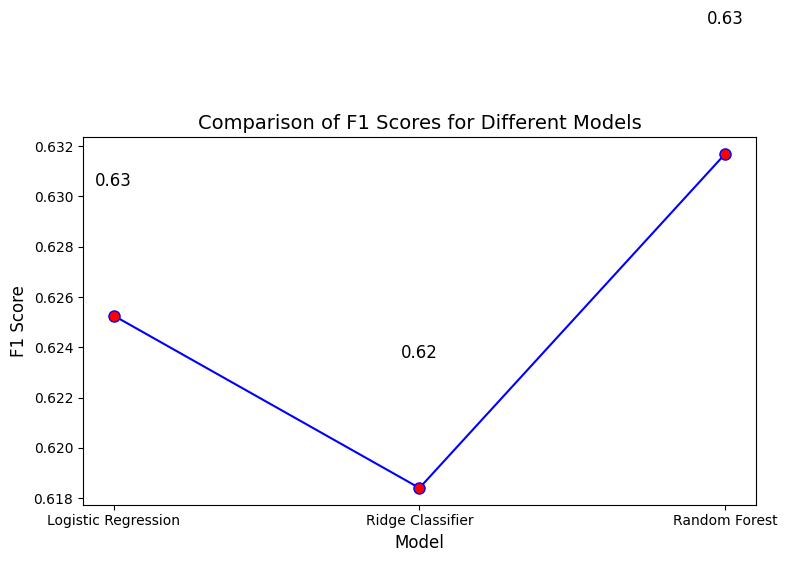

In [27]:
plt.figure(figsize=(8, 6))

# Create a line plot
plt.plot(model_names, f1_scores, marker='o', linestyle='-', color='b', markerfacecolor='red', markersize=8)

# Add annotations for each point
for i, score in enumerate(f1_scores):
    plt.text(model_names[i], score + 0.005, f'{score:.2f}', ha='center', va='bottom', fontsize=12)

# Add titles and labels
plt.title('Comparison of F1 Scores for Different Models', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# SAVE THE BEST MODEL

In [31]:
import joblib

# Save the trained model to a pickle file
joblib.dump(rndf_model, 'rndf_model.pkl')

PicklingError: Can't pickle <class '__main__.CustomPreprocessor'>: it's not the same object as __main__.CustomPreprocessor

# USE FAST API TO DEPLOY MODEL

In [34]:
from fastapi import FastAPI
import joblib
import numpy as np

# Initialize FastAPI app
app = FastAPI()

# Load the saved model
model = joblib.load('rndf_model.pkl')

@app.post("/predict/")
async def predict(features: list):
    """
    Endpoint to make predictions.
    :param features: List of input features for prediction.
    :return: Predicted class or probabilities.
    """
    # Convert input features to a NumPy array
    input_data = np.array(features).reshape(1, -1)
    
    # Make prediction using the loaded model
    prediction = model.predict(input_data)
    
    return {"prediction": prediction.tolist()}


EOFError: 